# FreeBirds Crew
Quick Draw - A Google Doodle Recognition Clone

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset.

In [ ]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2024-04-19 06:21:11--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-04-19 06:21:11 ERROR 404: Not Found.



Read the classes names

In [7]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [8]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset

Loop over the classes and download the currospondent data

In [9]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [10]:
import urllib.request
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [11]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports

In [1]:
import os
import glob
import numpy as np
from tensorflow.python.keras import layers
from tensorflow import keras
import tensorflow as tf

print(len(os.listdir('data')))

100


# Load the Data

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [2]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [3]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [4]:
print(len(x_train))

320000


Show some random data

airplane


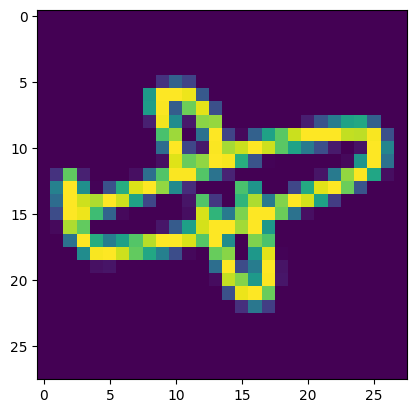

In [24]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

# Preprocess the Data

In [25]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model

In [45]:
# Define model
from keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten

model = keras.Sequential()
model.add(Convolution2D(16, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size =(2,2)))
model.add(Convolution2D(128, (3, 3), padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size =(2,2)))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(100, activation='softmax'))

# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 100)                 │          12,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,564 (494.39 KB)

 Trainable params: 126,564 (494.39 KB)

 Non-trainable params: 0 (0.00 B)

None


# Training

In [46]:
model.fit(x = x_train, y = y_train, validation_split=0.05, batch_size = 512, verbose=2, epochs=50)

Epoch 1/50
594/594 - 13s - 22ms/step - loss: 2.2482 - top_k_categorical_accuracy: 0.7240 - val_loss: 1.5647 - val_top_k_categorical_accuracy: 0.8554
Epoch 2/50
594/594 - 5s - 8ms/step - loss: 1.4079 - top_k_categorical_accuracy: 0.8737 - val_loss: 1.3090 - val_top_k_categorical_accuracy: 0.8842
Epoch 3/50
594/594 - 4s - 7ms/step - loss: 1.2078 - top_k_categorical_accuracy: 0.8974 - val_loss: 1.1665 - val_top_k_categorical_accuracy: 0.9013
Epoch 4/50
594/594 - 4s - 7ms/step - loss: 1.0983 - top_k_categorical_accuracy: 0.9096 - val_loss: 1.0724 - val_top_k_categorical_accuracy: 0.9107
Epoch 5/50
594/594 - 5s - 8ms/step - loss: 1.0244 - top_k_categorical_accuracy: 0.9177 - val_loss: 1.0318 - val_top_k_categorical_accuracy: 0.9147
Epoch 6/50
594/594 - 4s - 7ms/step - loss: 0.9710 - top_k_categorical_accuracy: 0.9227 - val_loss: 0.9933 - val_top_k_categorical_accuracy: 0.9203
Epoch 7/50
594/594 - 4s - 7ms/step - loss: 0.9282 - top_k_categorical_accuracy: 0.9272 - val_loss: 0.9641 - val_top_

# Testing

In [47]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.74%


# Inference

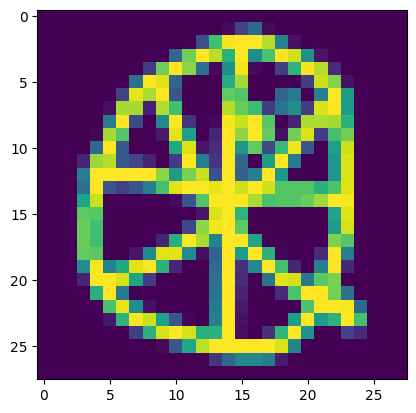

In [48]:
import matplotlib.pyplot as plt
from random import randint
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]

plt.imshow(img.squeeze())


In [49]:
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
['pizza', 'wheel', 'basketball', 'fan', 'baseball']


# Store the classes

In [94]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [95]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
  Attempting uninstall: ml-dtypes
    

# Save and Convert

In [ ]:
model.save('freebirdscrrew.keras')

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model

In [ ]:
from google.colab import files
files.download('model.zip')